In [142]:
import sys
print(sys.executable)

/usr/local/bin/python3.11


In [143]:
import matlab.engine

import pylab
import numpy as np
import scipy.integrate as scp
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import csv
import os
import sys
import copy
import numpy.random as rnd
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import pandas as pd
import math

from scipy.optimize import differential_evolution


# Since sobol_seq is installed via pip, it doesn't require an import test here, but you could do:
import sobol_seq

print("All modules are installed and imported successfully.")

All modules are installed and imported successfully.


In [144]:
#current directory
dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# open the folder called Data
dir = os.path.join(dir, 'Data')
file_path_1 = os.path.join(dir, '30State_Traj1_for5min_0405.csv')
file_path_2 = os.path.join(dir, '30State_Traj2_for5min_0405.csv')
file_path_3 = os.path.join(dir, '30State_Traj3_for5min_0405.csv')

df = pd.read_csv(file_path_1)
df.reset_index(drop=True, inplace=True)
data_raw1 = df.values

df = pd.read_csv(file_path_2)
df.reset_index(drop=True, inplace=True)
data_raw2 = df.values

df = pd.read_csv(file_path_3)
df.reset_index(drop=True, inplace=True)
data_raw3 = df.values

In [145]:
datasets = [data_raw1, data_raw2, data_raw3]
Xdat_list = []
Ydat_list = []
xt_real_list = []
controls_list = []
#xt_list = []
N_state = 30

for data_raw in datasets:
    # Extract indices for every state
    selected_indices = np.arange(0, len(data_raw[:, 0]), 300)[:N_state]
    data_state = data_raw[selected_indices, :]
    #check_sum = data_state[:, 2:6].sum(axis=1, keepdims=True)
    #print(f'check sum {check_sum.shape}')
    #data_state = np.hstack((data_state[:, :2], data_state[:, 2:6].sum(axis=1, keepdims=True), data_state[:, 7:])) # sum epsilon1-5 to get 'epsilon'
    print(f'data_state {data_state.shape}')
    Xdat_temp = data_state[:-1, :]
    Ydat_temp = data_state[1:, :-2] - data_state[:-1, :-2]
    controls_temp = data_state[:-1, -2:] # same as Xdat_temp[:,-2:]

    # Append the results to their respective lists
    Xdat_list.append(Xdat_temp)
    Ydat_list.append(Ydat_temp)
    xt_real_list.append(data_state.T)  # Transposed for consistency
    controls_list.append(controls_temp.T)

# Concatenate the lists into single arrays
###### why cant we train it without concatenate??
Xdat = np.concatenate(Xdat_list, axis=0)
Ydat = np.concatenate(Ydat_list, axis=0)

xt_real = np.stack(xt_real_list)
#xt_real = np.concatenate(xt_real_list, axis=1)  # Note the axis=1 due to transposition
controls = np.transpose(np.array(controls_list), axes=(1, 0, 2))
# xt = np.concatenate(xt_list, axis=1)

hp_0   = controls[0]
Qair_0 = controls[1]


data_state (30, 11)
data_state (30, 11)
data_state (30, 11)


# Build GP model without evolutionary algorithm

In [146]:
class GP_model_1:

    ###########################
    # --- initializing GP --- #
    ###########################
    def __init__(self, X, Y, kernel, multi_hyper, var_out=True):

        # GP variable definitions
        self.X, self.Y, self.kernel = X, Y, kernel
        self.n_point, self.nx_dim   = X.shape[0], X.shape[1]
        self.ny_dim                 = Y.shape[1]
        self.multi_hyper            = multi_hyper
        self.var_out                = var_out

        # normalize data
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        # determine hyperparameters
        self.hypopt, self.invKopt   = self.determine_hyperparameters()

    #############################
    # --- Covariance Matrix --- #
    #############################

    def Cov_mat(self, kernel, X_norm, W, sf2):
        '''
        Calculates the covariance matrix of a dataset Xnorm
        --- decription ---
        '''

        if kernel == 'RBF':
            dist       = cdist(X_norm, X_norm, 'seuclidean', V=W)**2
            cov_matrix = sf2*np.exp(-0.5*dist)

            return cov_matrix
            # Note: cdist =>  sqrt(sum(u_i-v_i)^2/V[x_i])
        else:
            print('ERROR no kernel with name ', kernel)

    ################################
    # --- Covariance of sample --- #
    ################################

    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        '''
        Calculates the covariance of a single sample xnorm against the dataset Xnorm
        --- decription ---
        '''
        # internal parameters
        nx_dim = self.nx_dim
        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)

        return cov_matrix

    ###################################
    # --- negative log likelihood --- #
    ###################################

    def negative_loglikelihood(self, hyper, X, Y):
        '''
        --- decription ---
        '''
        # internal parameters
        n_point, nx_dim = self.n_point, self.nx_dim
        kernel          = self.kernel

        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        K       = self.Cov_mat(kernel, X, W, sf2)  # (nxn) covariance matrix (noise free)
        K       = K + (sn2 + 1e-8)*np.eye(n_point) # (nxn) covariance matrix
        K       = (K + K.T)*0.5                    # ensure K is simetric
        L       = np.linalg.cholesky(K)            # do a cholesky decomposition
        logdetK = 2 * np.sum(np.log(np.diag(L)))   # calculate the log of the determinant of K the 2* is due to the fact that L^2 = K
        invLY   = np.linalg.solve(L,Y)             # obtain L^{-1}*Y
        alpha   = np.linalg.solve(L.T,invLY)       # obtain (L.T L)^{-1}*Y = K^{-1}*Y
        NLL     = np.dot(Y.T,alpha) + logdetK      # construct the NLL

        return NLL

    ############################################################
    # --- Minimizing the NLL (hyperparameter optimization) --- #
    ############################################################

    def determine_hyperparameters(self):
        '''
        --- decription ---
        Notice we construct one GP for each output
        '''
        # internal parameters
        X_norm, Y_norm  = self.X_norm, self.Y_norm
        nx_dim, n_point = self.nx_dim, self.n_point
        kernel, ny_dim  = self.kernel, self.ny_dim
        Cov_mat         = self.Cov_mat


        lb               = np.array([-4.]*(nx_dim+1) + [-8.])  # lb on parameters (this is inside the exponential)
        ub               = np.array([4.]*(nx_dim+1) + [ -2.])   # lb on parameters (this is inside the exponential)
        bounds           = np.hstack((lb.reshape(nx_dim+2,1),
                                      ub.reshape(nx_dim+2,1)))
        multi_start      = self.multi_hyper                   # multistart on hyperparameter optimization
        multi_startvec   = sobol_seq.i4_sobol_generate(nx_dim + 2,multi_start)

        options  = {'disp':False,'maxiter':10000}          # solver options
        hypopt   = np.zeros((nx_dim+2, ny_dim))            # hyperparams w's + sf2+ sn2 (one for each GP i.e. output var)
        localsol = [0.]*multi_start                        # values for multistart
        localval = np.zeros((multi_start))                 # variables for multistart

        invKopt = []
        # --- loop over outputs (GPs) --- #
        for i in range(ny_dim):
            # --- multistart loop --- #
            for j in range(multi_start):
                #print('multi_start hyper parameter optimization iteration = ',j,'  input = ',i)
                hyp_init    = lb + (ub-lb)*multi_startvec[j,:]
                # --- hyper-parameter optimization --- #
                res = minimize(self.negative_loglikelihood,hyp_init,args=(X_norm,Y_norm[:,i])\
                               ,method='SLSQP',options=options,bounds=bounds,tol=1e-12)
                localsol[j] = res.x
                localval[j] = res.fun

            # --- choosing best solution --- #
            minindex    = np.argmin(localval)
            hypopt[:,i] = localsol[minindex]
            ellopt      = np.exp(2.*hypopt[:nx_dim,i])
            sf2opt      = np.exp(2.*hypopt[nx_dim,i])
            sn2opt      = np.exp(2.*hypopt[nx_dim+1,i]) + 1e-8

            # --- constructing optimal K --- #
            Kopt        = Cov_mat(kernel, X_norm, ellopt, sf2opt) + sn2opt*np.eye(n_point)
            # --- inverting K --- #
            invKopt     += [np.linalg.solve(Kopt,np.eye(n_point))]

        return hypopt, invKopt

    ########################
    # --- GP inference --- #
    ########################

    def GP_inference_np(self, x):
        '''
        --- decription ---
        '''
        nx_dim                   = self.nx_dim
        kernel, ny_dim           = self.kernel, self.ny_dim
        hypopt, Cov_mat          = self.hypopt, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.invKopt
        Xsample, Ysample         = self.X_norm, self.Y_norm
        var_out                  = self.var_out
        #(if input noise)
        #Sigma_w                = self.Sigma_w #(if input noise)

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        # --- Loop over each output (GP) --- #
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])
            # --- determine covariance of each output --- #
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            threshold = 1e-10
            var[i]  = max(1e-10, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error
            #var[i] = sf2opt + Sigma_w[i,i]/stdY[i]**2 - np.matmul(np.matmul(k.T,invK),k) #(if input noise)

        # --- compute un-normalized mean --- #
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2



        if var_out:
            return mean_sample, var_sample
        else:
            return mean_sample.flatten()[0]

In [147]:
GP_m_1 = GP_model_1(Xdat, Ydat, 'RBF', multi_hyper=10, var_out=True)

In [148]:
#######################################################
# --- Simulating GP (No uncertainty propagation)  --- #
#######################################################

class GP_simulate:

    ###########################
    # --- initializing GP --- #
    ###########################
    def __init__(self, GP, x0, controls):

        # variable inputs
        self.GP, self.x0 = GP, x0
        self.controls    = controls            # shape (nu, steps)
        self.steps       = controls.shape[1]

        # internal variable definition
        self.udim, self.ydim = controls.shape[0],  x0.shape[0]
        self.xdim            = controls.shape[0] + x0.shape[0]

    #####################################
    # --- one-step ahead prediction --- #
    #####################################

    def one_step(self, Xt):
        '''
        --- decription ---
        '''
        # internal variable definition
        GP = self.GP

        yt_mean, yt_std   = GP.GP_inference_np(Xt)

        return yt_mean, yt_std

    ####################################################################
    # --- multi-step ahead prediction (No uncertainty propagation) --- #
    ####################################################################

    def multi_step_noprop(self):
        '''
        --- decription ---
        '''
        # internal variable definition
        one_step, controls = self.one_step, self.controls
        steps, x0, ydim    = self.steps, self.x0, self.ydim

        # creating lists to store data (includes initial control, hence +1)
        Y_mean = np.zeros((steps,ydim))
        Y_std  = np.zeros((steps,ydim))

        # starting process
        xnew        = x0
        #Y_mean[0,:] = xnew
        Y_std[0,:]  = np.zeros((xnew.shape))

        # GP simulation
        for si in range(steps):
            x             = np.hstack((xnew,controls[:,si]))
            ymean, ysigma = one_step(x)
            xnew           = ymean + xnew

            Y_mean[si,:] = ymean
            Y_std[si,:]  = ysigma


        return Y_mean, Y_std

    ######################################################################
    # --- multi-step ahead prediction (WITH uncertainty propagation) --- #
    ######################################################################

    def multi_step_withprop(self):
        '''
        --- decription ---
        '''
        print('Uncertainty propagation only available for Gaussian kernel')
        # internal variable definition
        one_step, controls    = self.one_step, self.controls
        steps, x0, ydim, xdim = self.steps, self.x0, self.ydim, self.xdim
        step_Uncert_prop      = self.step_Uncert_prop
        n_controls, X_mean    = controls.shape[0], self.GP.X_mean

        # creating lists to store data (includes initial control, hence +1)
        Y_mean = np.zeros((steps+1,ydim))
        Y_std  = np.zeros((steps+1,ydim))

        # starting process
        xnew        = x0
        Y_mean[0,:] = xnew
        Y_std[0,:]  = np.zeros((xnew.shape))

        # GP simulation
        for si in range(steps):
            #print('============== step ============',si)

            if si == 0:
                x            = np.hstack((xnew,controls[:,si])) # add control
                ynew, ysigma = one_step(x)                      # compute next step
                ycov         = np.identity(ydim)*ysigma         # make matrix (ydim x ydim)
                xcov         = np.hstack(( ycov,
                                          np.zeros((ydim, n_controls)) )) # make matrix (ydim x xdim)
            else:
                xnew       = ynew
                x          = np.concatenate((xnew,controls[:,si]))           # add control

                xcov       = np.vstack((xcov, np.zeros((n_controls,xdim))))  # add control uncertaint make matrix (xdim x xdim)

                xcov       = xcov + np.identity((xcov.shape[0]))*X_mean*1e-6 # add positive definite term
                ynew, ycov = step_Uncert_prop(x, xcov)                       # step with uncertainty propagation
                ysigma     = np.diag(ycov)                                   # get diagonal elements for plotting
                xcov       = np.hstack(( ycov,
                                        np.zeros((ydim, n_controls)) ))      # make matrix (ydim x xdim)

            Y_mean[si+1,:] = ynew
            Y_std[si+1,:]  = ysigma

        return Y_mean, Y_std

    ###################################
    # --- Uncertainty propagation --- #
    ###################################

    def step_Uncert_prop(self, m, s):
        '''
        --- decription ---
        m = mean of input distribution
        s = standard deviation of input distribution
        '''
        # internal variable definition
        GP, xdim, ydim = self.GP, self.xdim, self.ydim
        hypopt, invKopt, n_point = GP.hypopt, GP.invKopt, GP.n_point
        stdX, stdY, meanX, meanY = GP.X_std, GP.Y_std, GP.X_mean, GP.Y_mean
        X_norm_train, Y_norm_train = GP.X_norm, GP.Y_norm

        # X = self.X

        # variable definition
        m = (m - meanX) / stdX  # normalize mean
        s = s / (stdX.reshape(xdim, 1) * stdX.reshape(1, xdim))  # normalize std
        mean = np.zeros(ydim)
        var = np.zeros([ydim, ydim])
        beta = np.zeros([n_point, ydim])
        k = np.zeros([n_point, ydim])
        z_a = np.zeros([xdim, n_point, n_point])
        kk = np.zeros([n_point, n_point])
        Q = np.zeros([n_point, n_point])

        # samples - mean value
        nu = X_norm_train - m.T  # (n_point, ydim)
        for a in range(ydim):
            sf2opt = np.exp(2 * hypopt[xdim, a])
            ellopt = np.exp(2 * hypopt[:xdim, a])
            Lambda = np.diag(ellopt)
            k[:, a] = np.diag(sf2opt * np.exp(-0.5 * nu @ pinv(Lambda) @ nu.T))

        # --- Loop over each output (GP) --- #
        for a in range(ydim):
            # --- parameters of each output --- #
            invK = invKopt[a]
            hyper = hypopt[:, a]
            ellopt, sf2opt = np.exp(2 * hyper[:xdim]), np.exp(2 * hyper[xdim])
            Lambda = np.diag(ellopt)  # diagonalize the vector

            # --- determine covariance of each output --- #
            # Begin computation of mean (same as original GP)
            beta[:, a] = invK @ Y_norm_train[:, a]
            aa = sf2opt / (np.sqrt(np.linalg.det(s @ pinv(Lambda) + np.eye(xdim))))
            q = aa * (np.diag(np.exp(-0.5 * nu @ pinv(s + Lambda) @ nu.T)))
            # output mean value
            mean[a] = beta[:, a].T @ q  # k.T*Kinv*y

            # --- begin computation of covariance --- #
            k[:, a] = np.log(sf2opt) + np.diag(-0.5 * nu @ pinv(Lambda) @ nu.T)
            z_a1 = pinv(Lambda) @ nu.T
            for b in range(a + 1):
                hyperb = hypopt[:, b]
                elloptb, sf2optb = np.exp(2 * hyperb[:xdim]), np.exp(2 * hyperb[xdim])
                Lambdab = np.diag(elloptb)
                k[:, b] = np.log(sf2optb) + np.diag(-0.5 * nu @ pinv(Lambdab) @ nu.T)
                R = s @ (pinv(Lambda) + pinv(Lambdab)) + np.eye(xdim)
                z_a2 = pinv(Lambdab) @ nu.T
                kk = k[:, a].reshape([1, n_point]).T + k[:, b].reshape([1, n_point])

                U1, s1, V1 = (np.linalg.svd((pinv(R) @ s), full_matrices=True))
                qq1 = U1 @ np.sqrt(np.diagflat(s1))
                qq2 = V1.T @ np.sqrt(np.diagflat(s1))
                Q = (np.exp(kk + 0.5 * cdist(z_a1.T @ qq1, -z_a2.T @ qq2,
                                             'euclidean', V=np.ones(xdim)) ** 2) / np.sqrt(np.linalg.det(R)))

                var[a, b] = beta[:, a].T @ Q @ beta[:, b] - mean[a] * mean[b] # off diagonal elements
                var[b, a] = var[a, b]
                if a == b:
                    var[a, a] = max(0., var[a, a] + sf2opt - np.trace(np.matmul(invK, Q))) # diagonal elements (numerical error might make negative)

        # --- compute un-normalized mean and variance --- #
        mean_sample = mean * stdY + meanY
        var_sample = var * (stdY.reshape(ydim, 1) * stdY.reshape(1, ydim))

        return mean_sample, var_sample

# Plotting training data for GP

/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_4661/420956970.py:169: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_4661/420956970.py:171: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(1e-10, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error


Experiment 1 - RMSPE: 0.11 % 
Experiment 1 - NLPD: -5.65 
Experiment 1 - MAPE: 0.07 % 
Experiment 2 - RMSPE: 0.07 % 
Experiment 2 - NLPD: -5.86 
Experiment 2 - MAPE: 0.04 % 
Experiment 3 - RMSPE: 0.14 % 
Experiment 3 - NLPD: -5.51 
Experiment 3 - MAPE: 0.09 % 


<Figure size 1400x900 with 0 Axes>

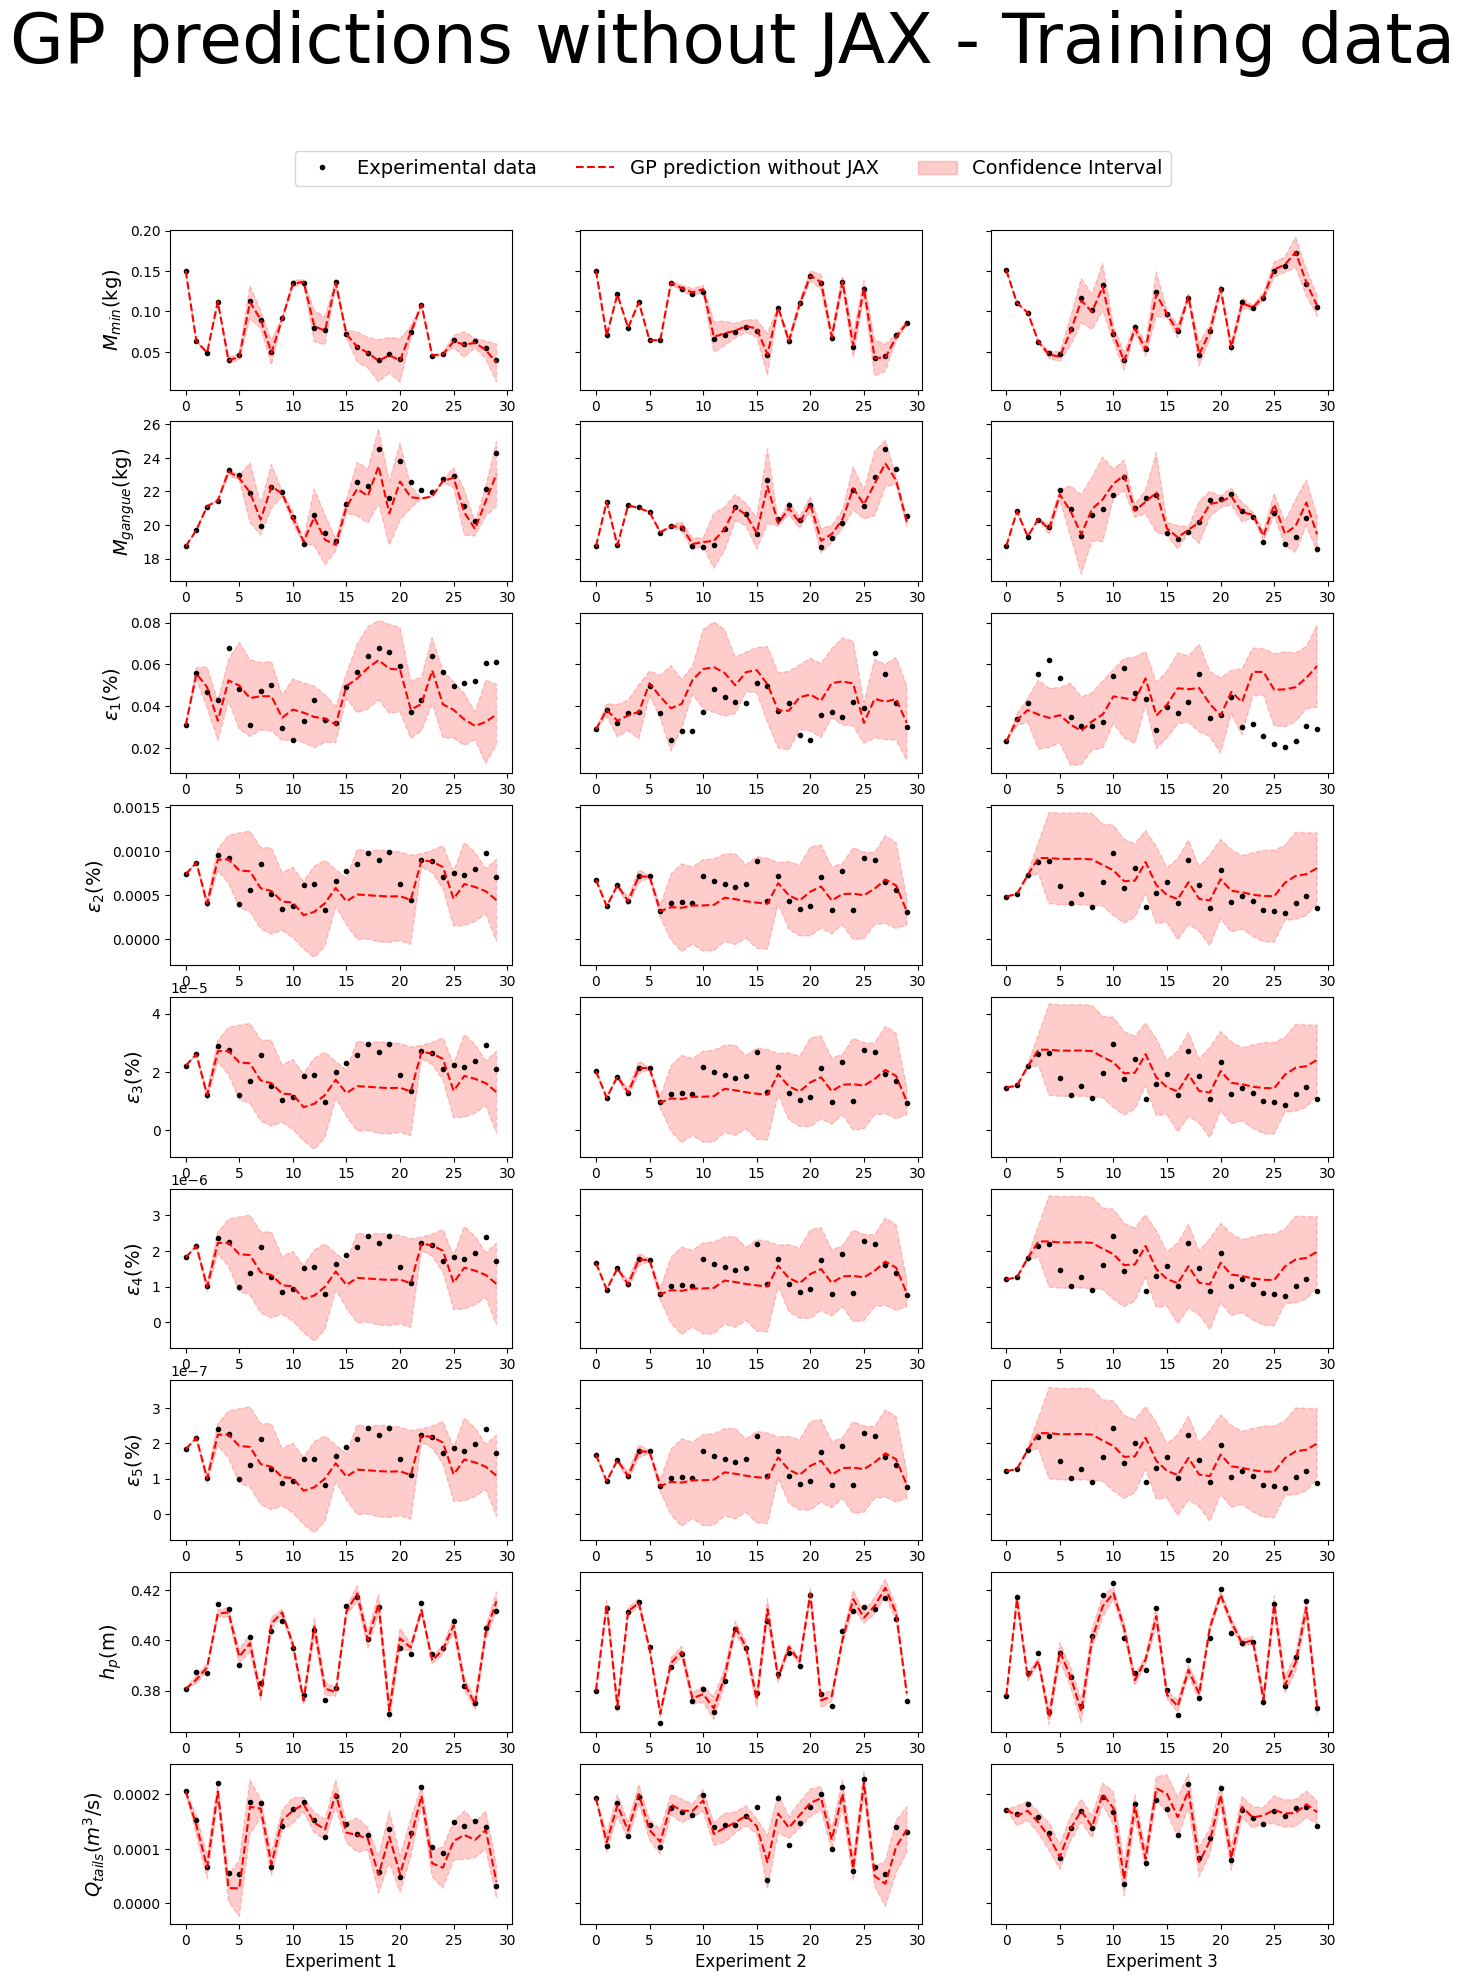

In [149]:
#######################################################
### Plot training data ###
#######################################################

'Extracting Dataset'
dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# open the folder called Data
dir = os.path.join(dir, 'Data')
file_path_4 = os.path.join(dir, '30State_Traj1_for5min_0405.csv')
file_path_5 = os.path.join(dir, '30State_Traj2_for5min_0405.csv')
file_path_6 = os.path.join(dir, '30State_Traj3_for5min_0405.csv')

df = pd.read_csv(file_path_4)
df.reset_index(drop=True, inplace=True)
data_raw4 = df.values

df = pd.read_csv(file_path_5)
df.reset_index(drop=True, inplace=True)
data_raw5 = df.values

df = pd.read_csv(file_path_6)
df.reset_index(drop=True, inplace=True)
data_raw6 = df.values

'Extracting Variables'
datasets = [data_raw4, data_raw5, data_raw6]
Xdat_list = []
Ydat_list = []
xt_real_list = []
controls_list = []
#xt_list = []
N_state = 30

for data_raw in datasets:
    # Extract indices for every state
    selected_indices = np.arange(0, len(data_raw[:, 0]), 300)[:N_state] #Selected_indices = timestamps for which the sampling was done in the raw data
    data_state = data_raw[selected_indices, :] #Selected all the columns of the sampled rows (every 300th row selectes all the data from all columns)


    Xdat_temp = data_state[:-1, :] #All rows up to the last row and all the columns from the sample dataset
    Ydat_temp = data_state[1:, :-2] - data_state[:-1, :-2] #(All rows except the first one and all columns except the last two). Subtracting each from the row that follows it. The delta.
    controls_temp = data_state[:-1, -2:] # same as Xdat_temp[:,-2:]

    # Append the results to their respective lists
    Xdat_list.append(Xdat_temp)
    Ydat_list.append(Ydat_temp)
    xt_real_list.append(data_state.T)  # Transposed for consistency
    controls_list.append(controls_temp.T)

# Concatenate the lists into single arrays
###### why cant we train it without concatenate??
Xdat = np.concatenate(Xdat_list, axis=0) #Xdat is 29 samples of every column (11) from each of the 3 datasets, because need Ydat and Xdat dimensions to be the same and Ydat is 30-1. Therefore 30-3.
                                         #Xdat shape is (87,11)

Ydat = np.concatenate(Ydat_list, axis=0) #Ydat is the delta between all the states for the 30 samples.
                                         #Ydat shape is (87,9)
xt_real = np.stack(xt_real_list)

#xt_real = np.concatenate(xt_real_list, axis=1)  # Note the axis=1 due to transposition
controls = np.transpose(np.array(controls_list), axes=(1, 0, 2))
# xt = np.concatenate(xt_list, axis=1)


hp_0   = controls[0]
Qair_0 = controls[1] #Samples 300th row 30 times but theres only 29 elements in these lists?


'Plotting Data'


# --- problem parameters --- #
experiments = 3  # number of trajectories
steps_ = (N_state - 1)
nd = 9  # number of state variable
nu = 2  # number of controlled variable
x0 = xt_real[:, 0:-2, 0]  # current state (specified initial state) defined as x0

tt = range(N_state)
# --- input arrays --- # (training)
hp_np = np.array(hp_0)
Qair_np = np.array(Qair_0)

# --- data collectors --- #
Xreal = np.zeros((experiments * steps_, nd + nu))
Yreal = np.zeros((experiments * steps_, nd))
Delta_YmeanGP = np.zeros((experiments, steps_, nd))
Delta_YstdGP = np.zeros((experiments, steps_, nd))

# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(14, 9)
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments+2))
state_indices = [0,1,2, 3, 4, 5, 6,7,8]


for run_i in range(controls.shape[1]):  # controls.shape[1]= experiment
    GP_run = GP_simulate(GP_m_1, x0[run_i, :], controls[:, run_i, :])
    Delta_YmeanGP[run_i, :, :], Delta_YstdGP[run_i, :, :] = GP_run.multi_step_noprop()
    # print(f'check deltaY {Delta_YmeanGP.shape}')
    
    cumulative_deltaYmean = np.cumsum(Delta_YmeanGP[run_i, :, :], axis=0)
    YmeanGP = cumulative_deltaYmean + x0[run_i, :]
    # print(f'check YmeanGP1 {YmeanGP.shape}')
    
    # Reshape and concatenate to include the initial state
    YmeanGP = np.concatenate([x0[run_i, :].reshape(1, -1), YmeanGP], axis=0)  # final array with shape (steps_ + 1, nd)
    # print(f'check YmeanGP2 {YmeanGP.shape}')

    YstdGP = np.concatenate([np.zeros((1, nd)), Delta_YstdGP[run_i, :, :]], axis=0)
    # print(f'check YstdGP {YstdGP.shape}')

    if run_i == 0:
        # Initialize the final arrays to store results for all experiments
        YmeanGP_m_1 = np.zeros((experiments, steps_ + 1, nd))
        YstdGP_m_1 = np.zeros((experiments, steps_ + 1, nd))

    YmeanGP_m_1[run_i, :, :] = YmeanGP
    YstdGP_m_1[run_i, :, :] = YstdGP


#self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

def calculate_rmspe(Y_true, Y_pred):
    return np.sqrt(np.mean(((Y_true - Y_pred) / Y_true)**2)) * 100

# def calculate_Rsquared(Y_true, Y_pred):
#     ss_tot = np.sum((Y_true - np.mean(Y_true))**2)
#     ss_res = np.sum((Y_true - Y_pred)**2)
#     return 1 - (ss_res / ss_tot)

def calculate_nlpd(Y_true, Y_pred, Y_std):
    Y_std = np.maximum(Y_std, 1e-3)
    return np.mean((Y_true - Y_pred)**2 / (2 * Y_std**2) + 0.5 * np.log(2 * np.pi * Y_std**2))

def calculate_mape(Y_true, Y_pred):
    return np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100

rmspe_gp_m_1 = np.zeros((experiments, len(state_indices)))
# r2_gp_m_1 = np.zeros((experiments, len(state_indices)))
mape_gp_m_1 = np.zeros((experiments, len(state_indices)))
nlpd_gp_m_1 = np.zeros((experiments, len(state_indices)))

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        #Z-score normalisation
        Y_true = xt_real[exp, :-2, state]
        Y_pred = YmeanGP_m_1[exp, state, :]
        Y_std = np.sqrt(YstdGP_m_1[exp, state, :])

        Y_true_normalised = (Y_true - np.mean(Y_true)) / np.std(Y_true)
        Y_pred_normalised = (Y_pred - np.mean(Y_pred)) / np.std(Y_pred)
        Y_std_normalised = (Y_std) / np.std(Y_pred)

        rmspe_gp_m_1[exp, idx] = calculate_rmspe(Y_true_normalised, Y_pred_normalised)
        # r2_gp_m_1[exp, idx] = calculate_Rsquared(Y_true_normalised, Y_pred_normalised)
        mape_gp_m_1[exp, idx] = calculate_mape(Y_true_normalised, Y_pred_normalised)
        nlpd_gp_m_1[exp, idx] = calculate_nlpd(Y_true_normalised, Y_pred_normalised, Y_std_normalised)

# --- plotting --- #
# Define indices of states to plot

num_states = len(state_indices)

# Define a new set of distinct colors using a colormap
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments + 8))
# --- plot options --- #
fig, axs = plt.subplots(num_states, experiments,figsize=(15, 22), sharey='row')  # Change to (num_states, experiments)
fig_title = [r'$M_{min}$(kg)', r'$M_{gangue}$(kg)', r'$\varepsilon_1$(%) ', r'$\varepsilon_2$(%) ', r'$\varepsilon_3$(%)', r'$\varepsilon_4$(%)', r'$\varepsilon_5$(%)', r'$h_p$(m)', r'$Q_{tails}$($m^3$/s)']
handles = []
labels = []

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        ax = axs[idx, exp]  # Access subplot by (state, experiment)

        x_r = xt_real[exp, :-2, :]  # Assuming shape to be (n_vars, n_steps)
        
        # Plot the real system trajectory (dashed line)
        handle_real, = ax.plot(tt, x_r[state, :], '.', label=f'Real data', color='black')
        
        
        # Plot GP_m_1 mean and CI
        handle_gp_m_1, = ax.plot(tt, YmeanGP_m_1[exp, :, state], label=f'GP prediction {exp + 1}', linestyle='--', color='red')
        ax.fill_between(tt, YmeanGP_m_1[exp, :, state] - 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        YmeanGP_m_1[exp, :, state] + 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        color='red', alpha=0.2, linestyle='--')
        
        if exp == 0:
            ax.set_ylabel(fig_title[state], fontsize=14)  # Set the title as the ylabel for each state

        if idx == num_states - 1:
            ax.set_xlabel(f'Experiment {exp+1}', fontsize=12)


        # Collect handles and labels for legend
        if idx == 0 and exp == 0:
            # Create a custom patch for the confidence region
            confidence_patch = Patch(color='red', alpha=0.2, label='Confidence Interval')
            
            handles.extend([handle_real, handle_gp_m_1, confidence_patch])
            labels.extend([f'Experimental data', 'GP prediction without JAX', 'Confidence Interval'])
    
        # Annotate RMSE, MAE, NLPD
    #ax.text(0.05, 0.85, f'Percentage Error GP: {overall_percentage_error:.2f}%', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.75, f'MAE GP: {mae_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.05, f'NLPD GP: {nlpd_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='red')
    #fig.text(0.5, -0.05, f'Percentage Error GP: {overall_percentage_error:.2f}%', ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
        
        


# Create a single line of text with all experiment annotations
# annotation_text1 = " | ".join([f"Experiment {exp + 1} - RMSE: {np.mean(rmse_gp_m_1[exp]):.6f} "
#                              for exp in range(experiments)])

# annotation_text2 = " | ".join([f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} "
#                              for exp in range(experiments)])

# annotation_text3 = " | ".join([f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} "
#                              for exp in range(experiments)])

# To add text at the bottom
# fig.text(0.5, -0.05, annotation_text1, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.07, annotation_text2, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.09, annotation_text3, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)

# Add a single legend outside the subplots
fig.suptitle('GP predictions without JAX - Training data', fontsize=50, ha='center')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=3, fontsize=14)

for exp in range(experiments):
    print (f"Experiment {exp + 1} - RMSPE: {np.mean(rmspe_gp_m_1[exp]):.2f} % ")
    print (f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} ")
    # print (f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} ")
    print (f"Experiment {exp + 1} - MAPE: {np.mean(mape_gp_m_1[exp]):.2f} % ")


# Plotting Testing Data Performance

/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_4661/420956970.py:169: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_4661/420956970.py:171: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(1e-10, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error


Experiment 1 - RMSPE: 0.15 % 
Experiment 1 - NLPD: -5.47 
Experiment 1 - MAPE: 0.09 % 
Experiment 2 - RMSPE: 0.24 % 
Experiment 2 - NLPD: -5.29 
Experiment 2 - MAPE: 0.14 % 
Experiment 3 - RMSPE: 0.36 % 
Experiment 3 - NLPD: -4.91 
Experiment 3 - MAPE: 0.20 % 


<Figure size 1400x900 with 0 Axes>

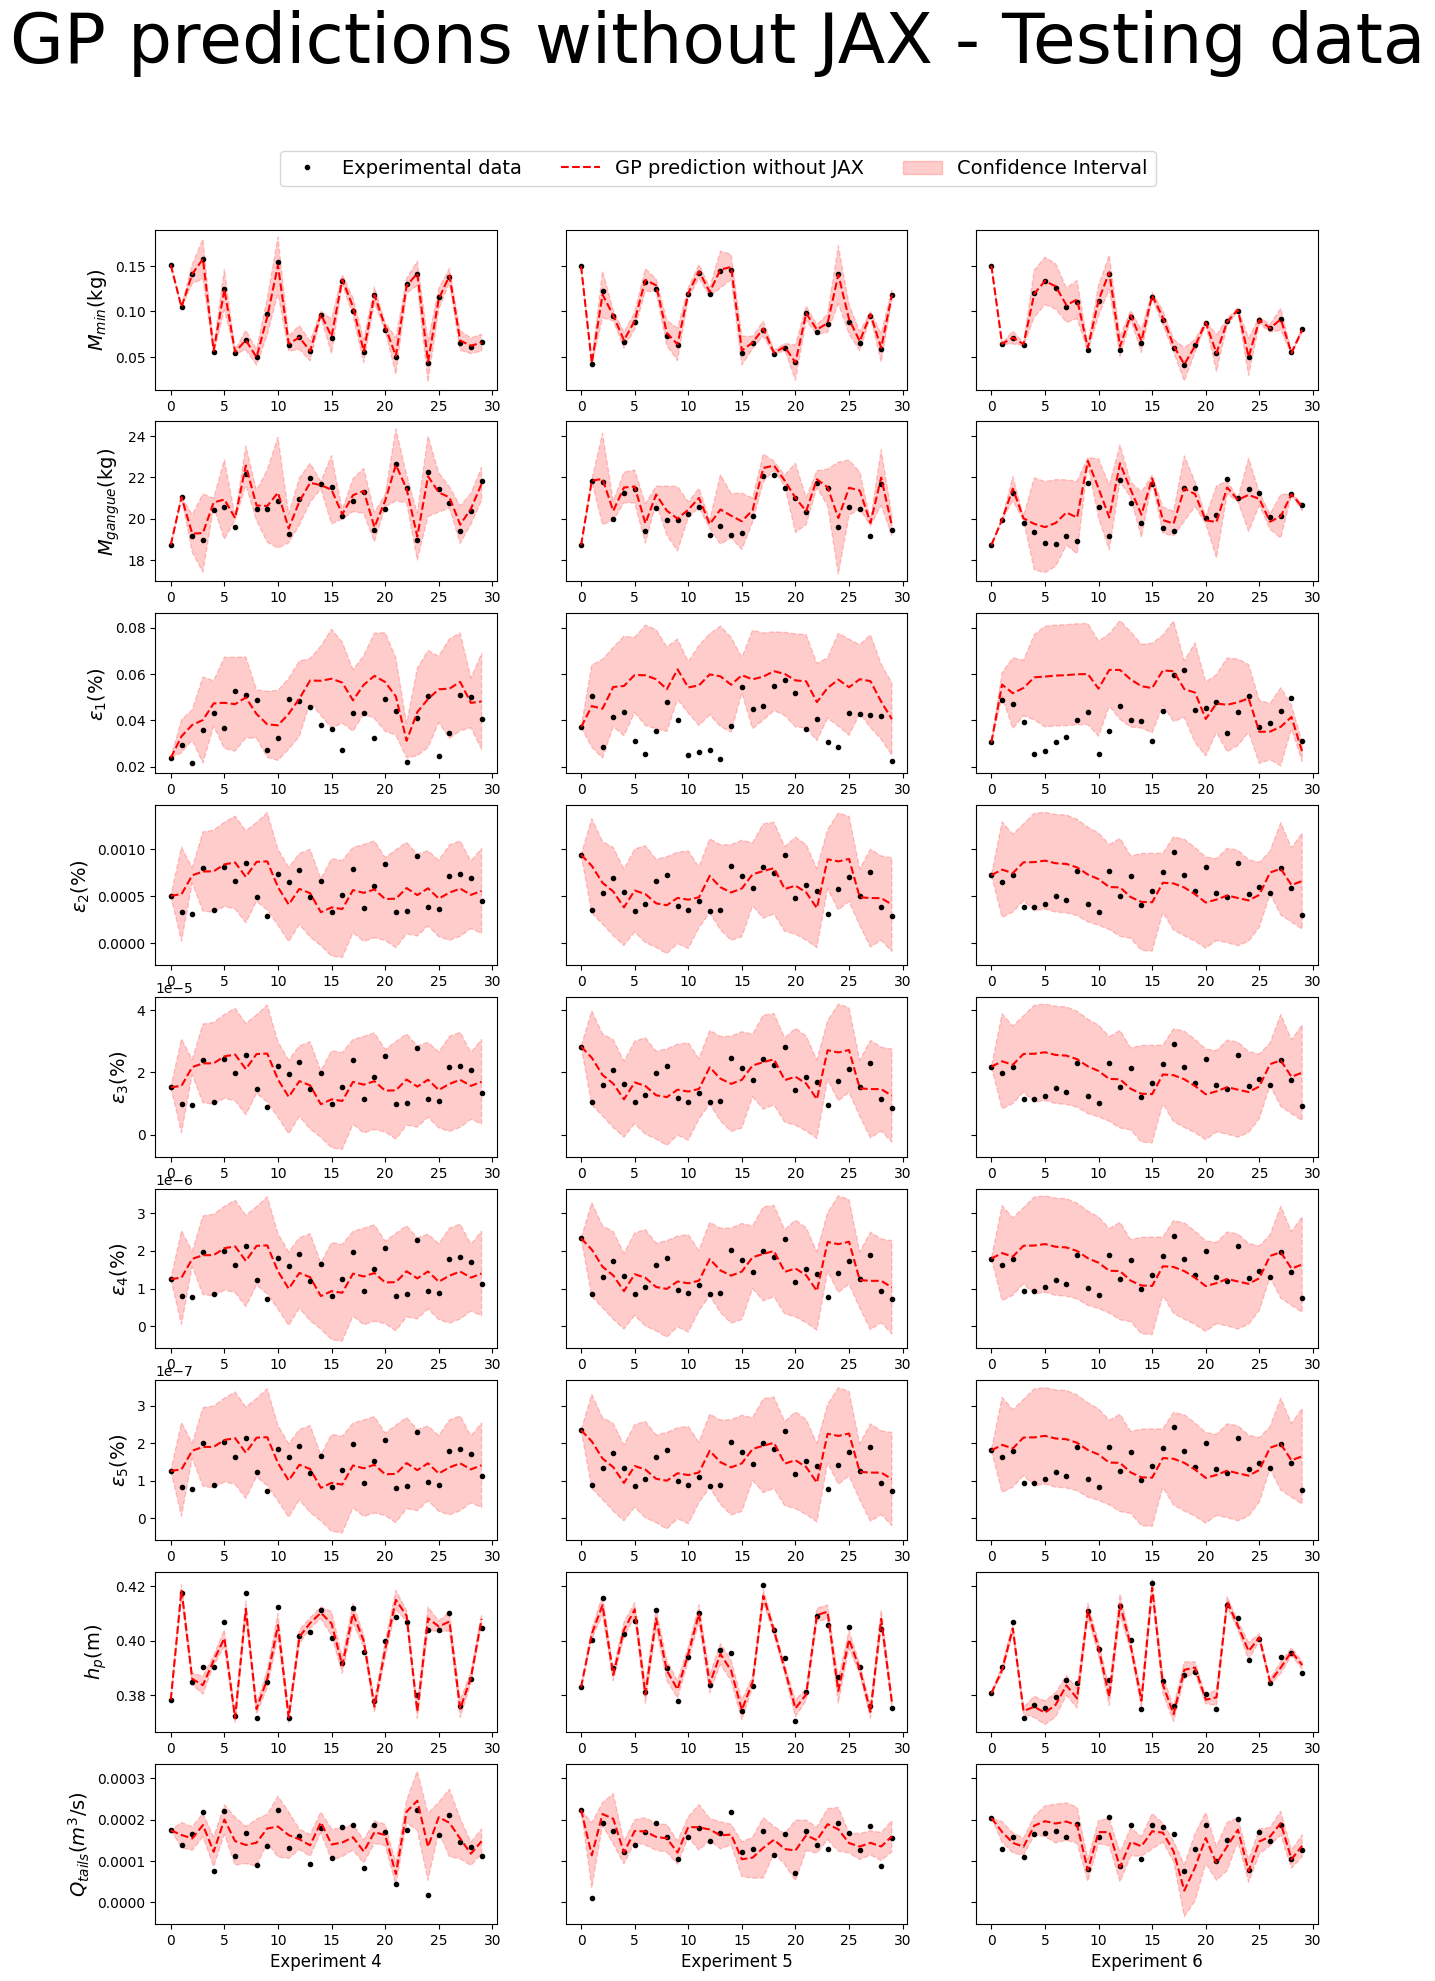

In [150]:
'Extracting Dataset'
dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# open the folder called Data
dir = os.path.join(dir, 'Data')
file_path_7 = os.path.join(dir, '30State_Traj4_for5min_0405.csv')
file_path_8 = os.path.join(dir, '30State_Traj5_for5min_0405.csv')
file_path_9 = os.path.join(dir, '30State_Traj6_for5min_0405.csv')

df = pd.read_csv(file_path_7)
df.reset_index(drop=True, inplace=True)
data_raw7 = df.values

df = pd.read_csv(file_path_8)
df.reset_index(drop=True, inplace=True)
data_raw8 = df.values

df = pd.read_csv(file_path_9)
df.reset_index(drop=True, inplace=True)
data_raw9 = df.values

'Extracting Variables'
datasets = [data_raw7, data_raw8, data_raw9]
Xdat_list = []
Ydat_list = []
xt_real_list = []
controls_list = []
#xt_list = []
N_state = 30

for data_raw in datasets:
    # Extract indices for every state
    selected_indices = np.arange(0, len(data_raw[:, 0]), 300)[:N_state] #Selected_indices = timestamps for which the sampling was done in the raw data
    data_state = data_raw[selected_indices, :] #Selected all the columns of the sampled rows (every 300th row selectes all the data from all columns)


    Xdat_temp = data_state[:-1, :] #All rows up to the last row and all the columns from the sample dataset
    Ydat_temp = data_state[1:, :-2] - data_state[:-1, :-2] #(All rows except the first one and all columns except the last two). Subtracting each from the row that follows it. The delta.
    controls_temp = data_state[:-1, -2:] # same as Xdat_temp[:,-2:]

    # Append the results to their respective lists
    Xdat_list.append(Xdat_temp)
    Ydat_list.append(Ydat_temp)
    xt_real_list.append(data_state.T)  # Transposed for consistency
    controls_list.append(controls_temp.T)

# Concatenate the lists into single arrays
###### why cant we train it without concatenate??
Xdat = np.concatenate(Xdat_list, axis=0) #Xdat is 29 samples of every column (11) from each of the 3 datasets, because need Ydat and Xdat dimensions to be the same and Ydat is 30-1. Therefore 30-3.
                                         #Xdat shape is (87,11)

Ydat = np.concatenate(Ydat_list, axis=0) #Ydat is the delta between all the states for the 30 samples.
                                         #Ydat shape is (87,9)
xt_real = np.stack(xt_real_list)

#xt_real = np.concatenate(xt_real_list, axis=1)  # Note the axis=1 due to transposition
controls = np.transpose(np.array(controls_list), axes=(1, 0, 2))
# xt = np.concatenate(xt_list, axis=1)


hp_0   = controls[0]
Qair_0 = controls[1] #Samples 300th row 30 times but theres only 29 elements in these lists?


'Plotting Data'


# --- problem parameters --- #
experiments = 3  # number of trajectories
steps_ = (N_state - 1)
nd = 9  # number of state variable
nu = 2  # number of controlled variable
x0 = xt_real[:, 0:-2, 0]  # current state (specified initial state) defined as x0

tt = range(N_state)
# --- input arrays --- # (training)
hp_np = np.array(hp_0)
Qair_np = np.array(Qair_0)

# --- data collectors --- #
Xreal = np.zeros((experiments * steps_, nd + nu))
Yreal = np.zeros((experiments * steps_, nd))
Delta_YmeanGP = np.zeros((experiments, steps_, nd))
Delta_YstdGP = np.zeros((experiments, steps_, nd))

# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(14, 9)
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments+2))
state_indices = [0,1,2, 3, 4, 5, 6,7,8]



for run_i in range(controls.shape[1]):  # controls.shape[1]= experiment
    GP_run = GP_simulate(GP_m_1, x0[run_i, :], controls[:, run_i, :])
    Delta_YmeanGP[run_i, :, :], Delta_YstdGP[run_i, :, :] = GP_run.multi_step_noprop()
    # print(f'check deltaY {Delta_YmeanGP.shape}')
    
    cumulative_deltaYmean = np.cumsum(Delta_YmeanGP[run_i, :, :], axis=0)
    YmeanGP = cumulative_deltaYmean + x0[run_i, :]
    # print(f'check YmeanGP1 {YmeanGP.shape}')
    
    # Reshape and concatenate to include the initial state
    YmeanGP = np.concatenate([x0[run_i, :].reshape(1, -1), YmeanGP], axis=0)  # final array with shape (steps_ + 1, nd)
    # print(f'check YmeanGP2 {YmeanGP.shape}')

    YstdGP = np.concatenate([np.zeros((1, nd)), Delta_YstdGP[run_i, :, :]], axis=0)
    # print(f'check YstdGP {YstdGP.shape}')

    if run_i == 0:
        # Initialize the final arrays to store results for all experiments
        YmeanGP_m_1 = np.zeros((experiments, steps_ + 1, nd))
        YstdGP_m_1 = np.zeros((experiments, steps_ + 1, nd))

    YmeanGP_m_1[run_i, :, :] = YmeanGP
    YstdGP_m_1[run_i, :, :] = YstdGP


def calculate_rmspe(Y_true, Y_pred):
    return np.sqrt(np.mean(((Y_true - Y_pred) / Y_true)**2)) * 100

# def calculate_Rsquared(Y_true, Y_pred):
#     ss_tot = np.sum((Y_true - np.mean(Y_true))**2)
#     ss_res = np.sum((Y_true - Y_pred)**2)
#     return 1 - (ss_res / ss_tot)

def calculate_nlpd(Y_true, Y_pred, Y_std):
    Y_std = np.maximum(Y_std, 1e-3)
    return np.mean((Y_true - Y_pred)**2 / (2 * Y_std**2) + 0.5 * np.log(2 * np.pi * Y_std**2))

def calculate_mape(Y_true, Y_pred):
    return np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100

rmspe_gp_m_1 = np.zeros((experiments, len(state_indices)))
# r2_gp_m_1 = np.zeros((experiments, len(state_indices)))
mape_gp_m_1 = np.zeros((experiments, len(state_indices)))
nlpd_gp_m_1 = np.zeros((experiments, len(state_indices)))

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        #Z-score normalisation
        Y_true = xt_real[exp, :-2, state]
        Y_pred = YmeanGP_m_1[exp, state, :]
        Y_std = np.sqrt(YstdGP_m_1[exp, state, :])

        Y_true_normalised = (Y_true - np.mean(Y_true)) / np.std(Y_true)
        Y_pred_normalised = (Y_pred - np.mean(Y_pred)) / np.std(Y_pred)
        Y_std_normalised = (Y_std) / np.std(Y_pred)

        rmspe_gp_m_1[exp, idx] = calculate_rmspe(Y_true_normalised, Y_pred_normalised)
        # r2_gp_m_1[exp, idx] = calculate_Rsquared(Y_true_normalised, Y_pred_normalised)
        mape_gp_m_1[exp, idx] = calculate_mape(Y_true_normalised, Y_pred_normalised)
        nlpd_gp_m_1[exp, idx] = calculate_nlpd(Y_true_normalised, Y_pred_normalised, Y_std_normalised)

# --- plotting --- #
# Define indices of states to plot

num_states = len(state_indices)

# Define a new set of distinct colors using a colormap
color_cycle = plt.cm.tab10(np.linspace(0, 1, experiments + 8))
# --- plot options --- #
fig, axs = plt.subplots(num_states, experiments,figsize=(15, 22), sharey='row')  # Change to (num_states, experiments)
fig_title = [r'$M_{min}$(kg)', r'$M_{gangue}$(kg)', r'$\varepsilon_1$(%) ', r'$\varepsilon_2$(%) ', r'$\varepsilon_3$(%)', r'$\varepsilon_4$(%)', r'$\varepsilon_5$(%)', r'$h_p$(m)', r'$Q_{tails}$($m^3$/s)']
handles = []
labels = []

for exp in range(experiments):
    for idx, state in enumerate(state_indices):
        ax = axs[idx, exp]  # Access subplot by (state, experiment)

        x_r = xt_real[exp, :-2, :]  # Assuming shape to be (n_vars, n_steps)
        
        # Plot the real system trajectory (dashed line)
        handle_real, = ax.plot(tt, x_r[state, :], '.', label=f'Real data', color='black')
        
        
        # Plot GP_m_1 mean and CI
        handle_gp_m_1, = ax.plot(tt, YmeanGP_m_1[exp, :, state], label=f'GP prediction {exp + 1}', linestyle='--', color='red')
        ax.fill_between(tt, YmeanGP_m_1[exp, :, state] - 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        YmeanGP_m_1[exp, :, state] + 2 * np.sqrt(YstdGP_m_1[exp, :, state]),
                        color='red', alpha=0.2, linestyle='--')
        
        if exp == 0:
            ax.set_ylabel(fig_title[state], fontsize=14)  # Set the title as the ylabel for each state

        if idx == num_states - 1:
            ax.set_xlabel(f'Experiment {exp+4}', fontsize=12)


        # Collect handles and labels for legend
        if idx == 0 and exp == 0:
            # Create a custom patch for the confidence region
            confidence_patch = Patch(color='red', alpha=0.2, label='Confidence Interval')
            
            handles.extend([handle_real, handle_gp_m_1, confidence_patch])
            labels.extend([f'Experimental data', 'GP prediction without JAX', 'Confidence Interval'])
    
        # Annotate RMSE, MAE, NLPD
    #ax.text(0.05, 0.85, f'Percentage Error GP: {overall_percentage_error:.2f}%', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.75, f'MAE GP: {mae_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')
        # ax.text(0.05, 0.05, f'NLPD GP: {nlpd_gp_m_1[exp, idx]:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='red')
    #fig.text(0.5, -0.05, f'Percentage Error GP: {overall_percentage_error:.2f}%', ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
        
        


# Create a single line of text with all experiment annotations
# annotation_text1 = " | ".join([f"Experiment {exp + 1} - RMSE: {np.mean(rmse_gp_m_1[exp]):.6f} "
#                              for exp in range(experiments)])

# annotation_text2 = " | ".join([f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} "
#                              for exp in range(experiments)])

# annotation_text3 = " | ".join([f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} "
#                              for exp in range(experiments)])

# To add text at the bottom
# fig.text(0.5, -0.05, annotation_text1, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.07, annotation_text2, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)
# fig.text(0.5, -0.09, annotation_text3, ha='center', fontsize=12, color='red', transform=plt.gcf().transFigure)

# Add a single legend outside the subplots
fig.suptitle('GP predictions without JAX - Testing data', fontsize=50, ha='center')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=3, fontsize=14)

for exp in range(experiments):
    print (f"Experiment {exp + 1} - RMSPE: {np.mean(rmspe_gp_m_1[exp]):.2f} % ")
    print (f"Experiment {exp + 1} - NLPD: {np.mean(nlpd_gp_m_1[exp]):.2f} ")
    # print (f"Experiment {exp + 1} - R^2: {np.mean(r2_gp_m_1[exp]):.8f} ")
    print (f"Experiment {exp + 1} - MAPE: {np.mean(mape_gp_m_1[exp]):.2f} % ")

In [151]:
# plot for cross-validation

dir = os.getcwd()
# go back one folder
dir = os.path.dirname(dir)
# go to the data folder
dir = os.path.join(dir, 'Data')
file_path_1 = os.path.join(dir, '30State_Traj4_for5min_0405.csv')


df  = pd.read_csv(file_path_1)
df.reset_index(drop=True, inplace=True)
data_raw = df.values
#data_raw = np.concatenate([data_raw[:, 0:3], data_raw[:, -2:]], axis=1)

# extract for every state (every 300 seconds)
N_state = 30
# still only have 30 points for every trajectory
selected_indices = np.arange(0,size(data_raw[:,0]),300)[:N_state] #added [:30] to take only 30 points, in case we are working with 100 states
data_state = data_raw[selected_indices,:]

# Prepare Xdat and Ydat based on state
Ydat = data_state[1:,:-2]-data_state[:-1,:-2]
Xdat = data_state[:-1,:]

# set xt and xt_real for convience and keep consistent with the code in GP model
xt_real = data_state.T
hp_0 = xt_real[-2, :]
Qair_0 = xt_real[-1, :]


# MPC Model

In [152]:
steps_ = 29
mpc_iters = steps_ 
mpc_runs_n = 1
controls = np.array([hp_0[:-1],Qair_0[:-1]]) # shape (nu, steps)
print ("Controls:", controls)
x00          = xt_real[0:-2,0]
horizon = 5 #control horizon
initial_guess = [[np.mean(hp_0[1:]), np.mean(Qair_0[1:])] * (horizon)]
initial_guess = np.array(initial_guess).reshape((horizon*nu))


# hp between 0.37 and 0.42 [metres]; Qair between 9x10^-4 and 3x10^-3 [m^3/s]
control_lb = np.array([0.37, 9*10**(-4)]*(horizon))
control_ub = np.array([0.42, 3*10**(-3)]*(horizon))
control_bounds = np.hstack((control_lb.reshape(horizon*nu,1), control_ub.reshape(horizon*nu, 1)))


def obj_func(controls, x0, horizon): #control here is only within the control_horizon of 5
  # Controls: repeat hp2 and Qair2 three more times ([0,1,2,2,2]) for control stability
  controls = controls.reshape((nu, horizon), order='F')
  controls[:, 3] = controls[:, 2]
  controls[:, 4] = controls[:, 2]

  #print(f'check control {controls}')
  #print(f'check control shape{controls.shape}')

  experiments = 1 # only have one experiment, so no loop here

  #compute GP model prediction for horizon
  # --- data collectors --- #
  Delta_YmeanGP = np.zeros((experiments, horizon, nd))
  Delta_YstdGP  = np.zeros((experiments, horizon, nd))
  # --- run GP model --- #

  GP_run                                = GP_simulate(GP_m_1, x0, controls[:,:])
  Delta_YmeanGP[:,:], Delta_YstdGP[:,:] = GP_run.multi_step_noprop()

  cumulative_deltaYmean = np.cumsum(Delta_YmeanGP[:,:,:], axis=1) #(1, 5, 8)
  YmeanGP = cumulative_deltaYmean + x0
  YmeanGP = np.vstack((x0, YmeanGP[0,:,:])) #(6,8)
  YmeanGP = YmeanGP.reshape(experiments, horizon+1, nd) #(1,6,9) reshape the size for dimension convience, not nescessary
  YstdGP  = np.vstack((np.zeros((x0.shape)), Delta_YstdGP[0,:,:]))
  YstdGP  = YstdGP.reshape(experiments, horizon+1, nd) #(1,6,9) 


  max_vals = np.max(YstdGP[0,:,:], axis=0) 


  YstdGP_normalized = YstdGP / max_vals
  YstdGP_hp = YstdGP[0,1,7]
  std_penalty = np.sum(YstdGP_normalized[0,1,:]) 
  #print(f'std_penalty {std_penalty}')  

  # --- calculate objective --- #
  Delta_u = controls[:,:-1] - controls[:,1:] #(2,4)
  #print(f'check deltaU {Delta_u.shape}')
  Q = np.array([[100,0],[0,10**(6)]])
  u_penalty = (np.sum(Delta_u.T@Q@Delta_u))    #u_penalty = (Delta_u.T@Q@Delta_u) dimension issue. #check it should be always positive
  #Potentially change to delta U
    
  #print(f'u_penalty {u_penalty}')

  #calculate the return_term
  Mmin_final = YmeanGP[0,-1,0]
  hp         = YmeanGP[0,-1,7]
  hp_firststep = YmeanGP[0,1,7]
  total_epsilon = np.sum(YmeanGP[0,-1,2:6])
  A_cell = 0.181 # A_cell is the cross-sectional tank area
  C1_tails = Mmin_final/(hp*(1-total_epsilon)*A_cell) #threshold of control behaviour

  # make penalty term has the same order of magnitude as C1_tails
  '''
  if u_penalty != 0:
    factor = 10**(math.log10(C1_tails) - math.log10((u_penalty))) #
    #print(f'factor {factor}')
    u_penalty *= (factor/10000) # as u_penalty is some order of magnitude smaller than Mmin
  '''

  #print(f'result {C1_tails + u_penalty}')
  return C1_tails * 50 + u_penalty * 1 + std_penalty * 10 , C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon
  #C1_tails * 500, u_penalty, std_penalty * 10

def wrapper_func(controls, x0, horizon):
      return obj_func(controls, x0, horizon)[0]

def choose_uk(obj_func, controls, x0, horizon, initial_guess, control_bounds):
  # Wrap the objective function to only return the first output to minimize
  
  result = minimize(wrapper_func, args=(x0, horizon), x0=initial_guess,
                   bounds=control_bounds, method = 'SLSQP') # method = 'SLSQP' Result of this minimisation is the control (uk)

  # result = differential_evolution(wrapper_func, bounds=control_bounds, args=(x0,horizon), maxiter=2, popsize=5)

  # Call obj_func one more time to get the detailed results for logging
  _, C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon = obj_func(result.x, x0, horizon)

  return result.x, C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon


# == lists to compile results == #
data_mpc           = {}
data_mpc['X_list'] = np.zeros((nd, mpc_iters+1, mpc_runs_n))
data_mpc['U_list'] = np.zeros((nu, mpc_iters, mpc_runs_n))
#collect the value to plot later and track
C1_tails_values = []
u_penalty_values  = []
std_penalty_values  = []
YstdGP_hp_values = []
Mmin_final_values = []
hp_values = []
hp_firststep_values = []
total_epsilon_values = []
obj_func_values = []
total_time = []

for runs_j in range(mpc_runs_n):
    # initial state
    xk                             = x00
    data_mpc['X_list'][:,0,runs_j] = xk

    #print(f'check initial guess for run{runs_j}: {initial_guess}')

    # iteration counter
    if runs_j%5==0:
        print('iteration ',runs_j,' of ',mpc_runs_n)

    # iteration of MPC
    for mpc_i in range(mpc_iters): # in the range of total steps
        #setpoint
        start_time = time.time()
        xs = controls[:,mpc_i:min(mpc_i+horizon, mpc_iters)+1]
        print ("Setpoint:", xs)
        if xs.shape[1]<(horizon+1):
            h_c = horizon-xs.shape[1]+1
            h_c = np.array([xs[:,-1] for i in range(h_c)])
            xs = np.hstack((xs, h_c.T)) #control (make sure it has 5 points as required by horizon=5)
            
            
        uk, C1_tails, u_penalty, std_penalty, Mmin_final, hp, hp_firststep, YstdGP_hp, total_epsilon  = choose_uk(obj_func, xs, xk, horizon, initial_guess, control_bounds)# uk = [hp_0, Qair_0, hp_1, Qair_1, ..., hp_4, Qair_4]
        print('|||||||||||ITERATION', mpc_i +1, 'of',mpc_iters,'|||||||||||')
        print("State Check:", xk)
        print("Control Check", uk)
        print(f'check C1_talis {C1_tails}')
        print(f'check u_penalty {u_penalty}')
        print(f'check std_penalty {std_penalty}')
        C1_tails_values.append(C1_tails)
        u_penalty_values.append(u_penalty)
        std_penalty_values.append(std_penalty)
        YstdGP_hp_values.append(YstdGP_hp)
        Mmin_final_values.append(Mmin_final)
        hp_values.append(hp)
        hp_firststep_values.append(hp_firststep)
        total_epsilon_values.append(total_epsilon)
        obj_func_values.append(C1_tails * 500 + u_penalty*1 + 10* std_penalty)
        
        
        #print(f'uk shape {uk.shape}')
        #update initial guess for next call
        initial_guess = np.hstack((uk[:8], uk[6:8])) #[1, 2, 3, 4, 4]
        
        uk = uk[:2] # [hp_0, Qair_0] only extract the next control action      
        hp_ctrl = uk[0]  
        Qair_ctrl = uk[1]  
        
        M_min_0 = xk[0]
        M_gangue_0 = xk[1]
        Epsilon1_0 = xk[2]
        Epsilon2_0 = xk[3]
        Epsilon3_0 = xk[4]
        Epsilon4_0 = xk[5]
        Epsilon5_0 = xk[6]
        hp_gp_0 = xk[7]
        Qtails_0 = xk[8]
        
        
        # Call the MATLAB function and retrieve the outputs
        eng = matlab.engine.start_matlab()
        dir = os.getcwd()
        eng.addpath(dir)
        directory = os.path.join(dir, 'Matlab')

        eng.cd(directory)

        M_min_real, M_gangue_real, Epsilon_real, hp_real, Qtails_real= eng.main_data_generation_func_for_python(hp_ctrl, Qair_ctrl, M_min_0, M_gangue_0, Epsilon1_0,Epsilon2_0,Epsilon3_0,Epsilon4_0,Epsilon5_0, hp_gp_0, Qtails_0, nargout=5)
        eng.quit()
        xk = np.concatenate((np.array([[M_min_real]]), np.array([[M_gangue_real]]), np.array(Epsilon_real), np.array([[hp_real]]), np.array([[Qtails_real]])), axis=1)
        xk = np.squeeze(xk)
        
        #print(f'check xk shape {xk.shape} and type {type(xk)}')
        data_mpc['U_list'][:,mpc_i,runs_j]   = uk #Controls
        data_mpc['X_list'][:,mpc_i+1,runs_j] = xk #States

        end_time = time.time()
        time_taken = end_time - start_time
        total_time.append(time_taken)
        
        print ("Iteration",mpc_i,"Took", time_taken, "seconds")
print ("Total Time Taken:", sum(total_time), "seconds")      

Controls: [[0.41976949 0.38486734 0.3849122  0.39527141 0.4015535  0.37404312
  0.41525674 0.37545771 0.38690489 0.40731567 0.37242237 0.4001734
  0.40648547 0.40906885 0.4046266  0.38982604 0.40900878 0.4003933
  0.37524066 0.39747701 0.41452378 0.40671705 0.37364426 0.40991754
  0.40418578 0.40613623 0.37587464 0.38644071 0.40745657]
 [0.00159739 0.00103029 0.00099734 0.00249899 0.00108877 0.00253221
  0.00202092 0.0026342  0.00151734 0.00092171 0.00230262 0.00200482
  0.00238523 0.00150475 0.00206901 0.00102934 0.00160893 0.00245663
  0.00116857 0.00191898 0.00257782 0.0010078  0.00108591 0.00288032
  0.00117737 0.00113174 0.00224551 0.00227301 0.00212469]]
iteration  0  of  1
Setpoint: [[0.41976949 0.38486734 0.3849122  0.39527141 0.4015535  0.37404312]
 [0.00159739 0.00103029 0.00099734 0.00249899 0.00108877 0.00253221]]
|||||||||||ITERATION 1 of 29 |||||||||||
State Check: [1.50961684e-01 1.87380049e+01 2.37945688e-02 5.06882335e-04
 1.52068894e-05 1.24873027e-06 1.25910300e-07 3

/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_4661/420956970.py:169: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_4661/420956970.py:171: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(1e-10, sf2opt - np.matmul(np.matmul(k.T,invK),k)) # numerical error


Iteration 0 Took 9.131510019302368 seconds
Setpoint: [[0.38486734 0.3849122  0.39527141 0.4015535  0.37404312 0.41525674]
 [0.00103029 0.00099734 0.00249899 0.00108877 0.00253221 0.00202092]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


|||||||||||ITERATION 2 of 29 |||||||||||
State Check: [1.31319486e-01 1.96661517e+01 3.90949900e-02 5.75076970e-04
 1.71955206e-05 1.41175352e-06 1.42337047e-07 3.95936051e-01
 3.21247309e-04]
Control Check [0.37900457 0.0009     0.4199499  0.00091142 0.37000024 0.00289636
 0.37000024 0.00289636 0.37000024 0.00289636]
check C1_talis 0.591521167765023
check u_penalty 3.9935734590425636
check std_penalty 3.791536099110621
Iteration 1 Took 8.639012813568115 seconds
Setpoint: [[0.3849122  0.39527141 0.4015535  0.37404312 0.41525674 0.37545771]
 [0.00099734 0.00249899 0.00108877 0.00253221 0.00202092 0.0026342 ]]
|||||||||||ITERATION 3 of 29 |||||||||||
State Check: [2.01678548e-01 1.86237757e+01 1.88666524e-02 2.85096929e-04
 8.52789991e-06 7.00148528e-07 7.05910468e-08 3.78999333e-01
 3.31969940e-04]
Control Check [0.38222195 0.00107081 0.41588274 0.00108078 0.37000166 0.00277562
 0.37000166 0.00277562 0.37000166 0.00277562]
check C1_talis 0.5848681622218278
check u_penalty 2.921321756984

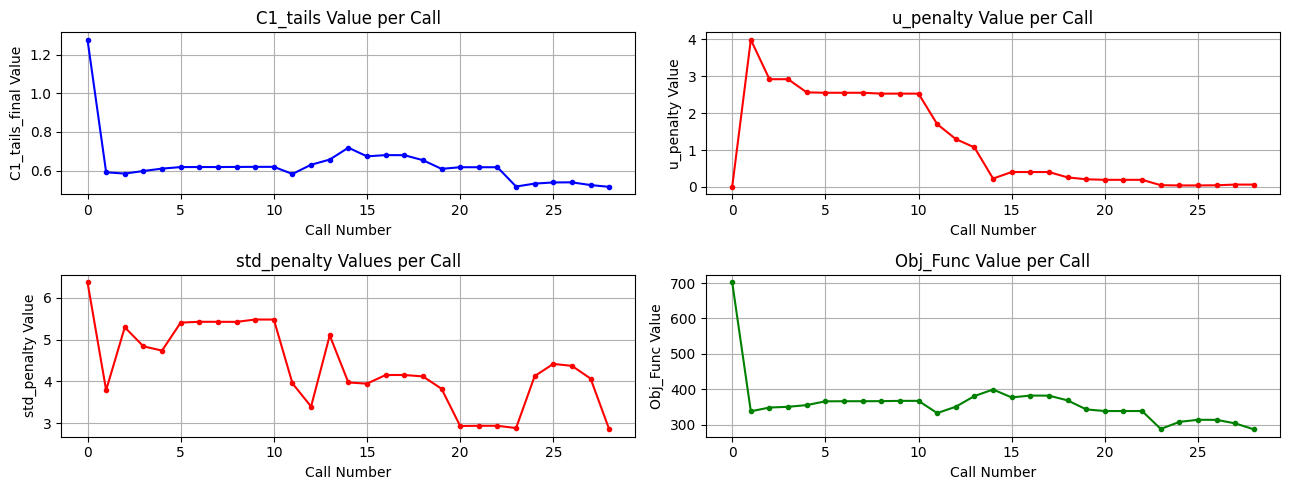

In [153]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(13, 5))

# Plot C1_tails values
axs[0,0].plot(C1_tails_values, marker='.', linestyle='-', color='b')
axs[0,0].set_title('C1_tails Value per Call')
axs[0,0].set_xlabel('Call Number')
axs[0,0].set_ylabel('C1_tails_final Value')
axs[0,0].grid(True)

# Plot u_penalty values
axs[0,1].plot(u_penalty_values, marker='.', linestyle='-', color='r')
axs[0,1].set_title('u_penalty Value per Call')
axs[0,1].set_xlabel('Call Number')
axs[0,1].set_ylabel('u_penalty Value')
axs[0,1].grid(True)

# Plot std_penalty values
axs[1,0].plot(std_penalty_values, marker='.', linestyle='-', color='r')
axs[1,0].set_title('std_penalty Values per Call')
axs[1,0].set_xlabel('Call Number')
axs[1,0].set_ylabel('std_penalty Value')
axs[1,0].grid(True)

#Plot objective function values
axs[1,1].plot(obj_func_values, marker='.', linestyle='-', color='g')
axs[1,1].set_title('Obj_Func Value per Call')
axs[1,1].set_xlabel('Call Number')
axs[1,1].set_ylabel('Obj_Func Value')
axs[1,1].grid(True)


plt.tight_layout()  # Adjust layout to not overlap
plt.show()


MAE_hp = 0.012431029098255067
MAE_Qair = 0.0007580935679994085
RMSE_hp = 0.015231840255182288
RMSE_Qair = 0.0009570854613177403
ISE_hp = 0.006728259769222358
ISE_Qair = 2.656436482770796e-05
Qtails: 0.00026128114360235465
C1_tails = 0.6306116759045315


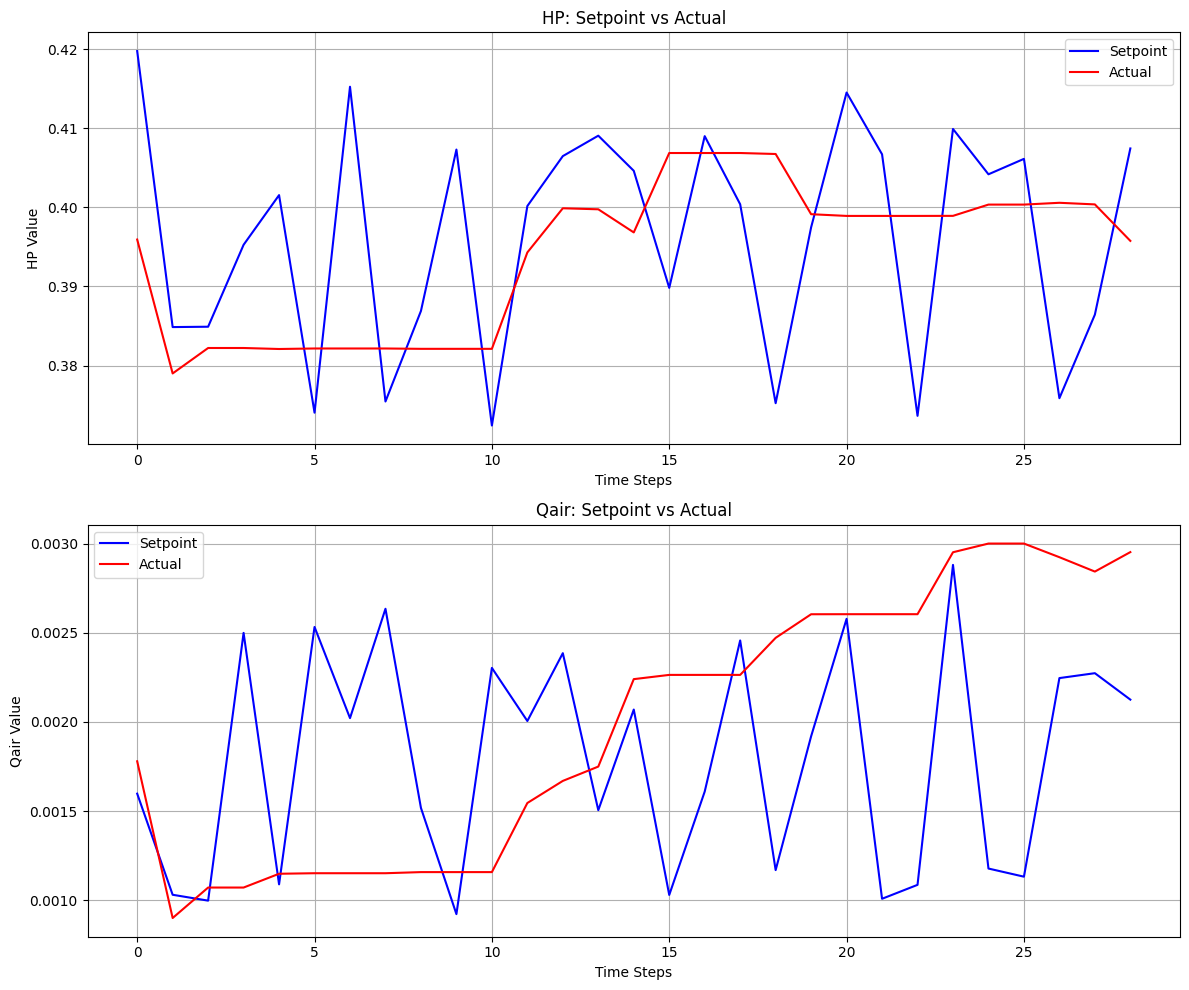

In [161]:
time_steps = np.arange(mpc_iters)

def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

def calculate_ise(actual, predicted):
    return np.sum((actual - predicted)**2)

# Setpoint values
setpoints_hp = controls[0, :]
setpoints_Qair = controls[1, :]

# Actual values from MPC
actual_hp = data_mpc['U_list'][:, :, 0][0]
actual_Qair = data_mpc['U_list'][:, :, 0][1]

# Calculate MAE and RMSE
MAE_hp = calculate_mae(actual_hp, setpoints_hp)
MAE_Qair = calculate_mae(actual_Qair, setpoints_Qair)
RMSE_hp = calculate_rmse(actual_hp, setpoints_hp)
RMSE_Qair = calculate_rmse(actual_Qair, setpoints_Qair)

# Calculate ISE
ISE_hp = calculate_ise(actual_hp, setpoints_hp)
ISE_Qair = calculate_ise(actual_Qair, setpoints_Qair)

# Print the results
print("MAE_hp =", MAE_hp)
print("MAE_Qair =", MAE_Qair)
print("RMSE_hp =", RMSE_hp)
print("RMSE_Qair =", RMSE_Qair)
print("ISE_hp =", ISE_hp)
print("ISE_Qair =", ISE_Qair)
print("Qtails:", np.mean(Qtails_real))
print("C1_tails =", np.mean(C1_tails_values))

# 'Plotting Control action VS Setpoint'
setpoints_hp = controls[0, :]
setpoints_Qair = controls[1, :]
actual_hp = data_mpc['U_list'][:, :, 0][0]
actual_Qair = data_mpc['U_list'][:, :, 0][1]


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot for hp
ax1.plot(time_steps, setpoints_hp, label='Setpoint', color='blue')
ax1.plot(time_steps, actual_hp, label='Actual', color='red')
ax1.set_title('HP: Setpoint vs Actual')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('HP Value')
ax1.legend()
ax1.grid(True)

# Plot for Qair
ax2.plot(time_steps, setpoints_Qair, label='Setpoint', color='blue')
ax2.plot(time_steps, actual_Qair, label='Actual', color='red')
ax2.set_title('Qair: Setpoint vs Actual')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Qair Value')
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

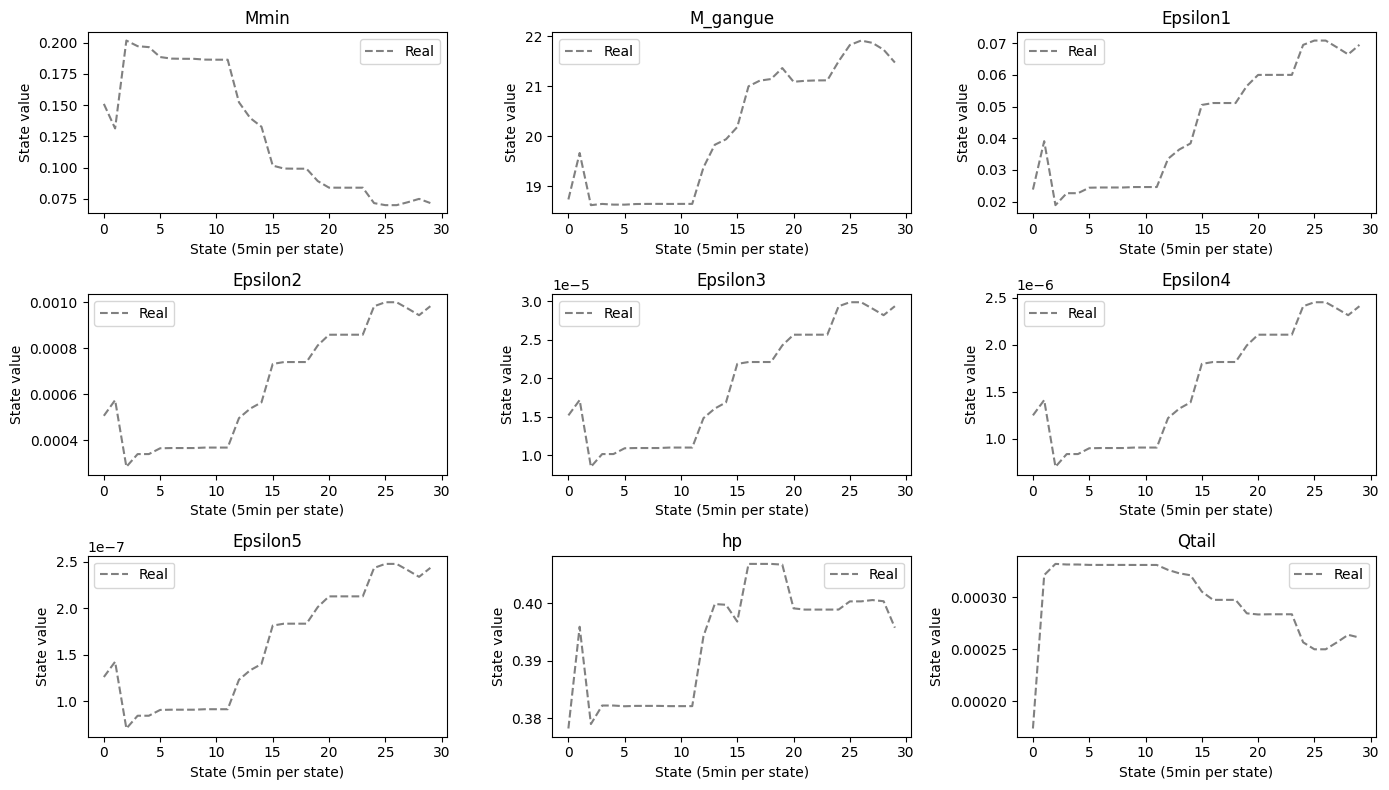

In [155]:
fig_titles = ['Mmin', 'M_gangue', 'Epsilon1', 'Epsilon2', 'Epsilon3', 'Epsilon4', 'Epsilon5', 'hp', 'Qtail']
fig, axes = plt.subplots(3, 3, figsize=(14,8))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for x_i in range(9):
    ax = axes[x_i]  # Select the appropriate subplot

    # Plot real data (the experimental trajectory from matlab)
    #ax.plot(xt_real[x_i], '--', color='red', label='training data')
    # Plot predicted data for each state variable from MPC runs
    
    # Plot real data (the experimental trajectory from matlab)
    for run_i in range(mpc_runs_n):
        ax.plot(list(data_mpc['X_list'][x_i,:,run_i]), '--', color='grey', label='Real' if run_i == 0 else "")

    ax.set_title(fig_titles[x_i])
    ax.set_ylabel('State value')
    ax.set_xlabel('State (5min per state)')
    ax.legend()
    
plt.tight_layout()  # Adjust subplot parameters to fit into the figure area
plt.show()

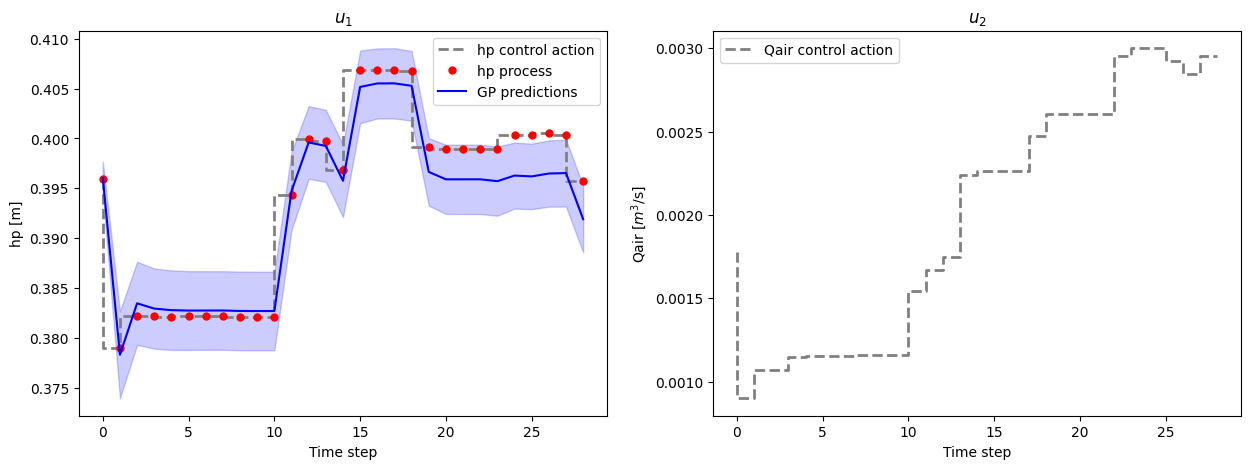

In [156]:

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].step(data_mpc['U_list'][0, :, 0],  '--', color='grey', label='hp control action', linewidth=2)
ax[0].plot(data_mpc['X_list'][7, 1:30, 0], '.', color='red', label='hp process', markersize=10)
ax[0].plot(hp_firststep_values, 'b-', label='GP predictions')
ax[0].fill_between(range(29), hp_firststep_values - 2*np.sqrt(YstdGP_hp_values), hp_firststep_values + 2*np.sqrt(YstdGP_hp_values), color='b', alpha=0.2)
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('hp [m]')
ax[0].legend(loc='best')
ax[0].title.set_text('$u_1$')
ax[1].step(data_mpc['U_list'][1, :, 0],  '--', color='grey', label='Qair control action', linewidth=2) #/0.181*100
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Qair [$m^3$/s]')
ax[1].legend(loc='best')
ax[1].title.set_text('$u_2$')

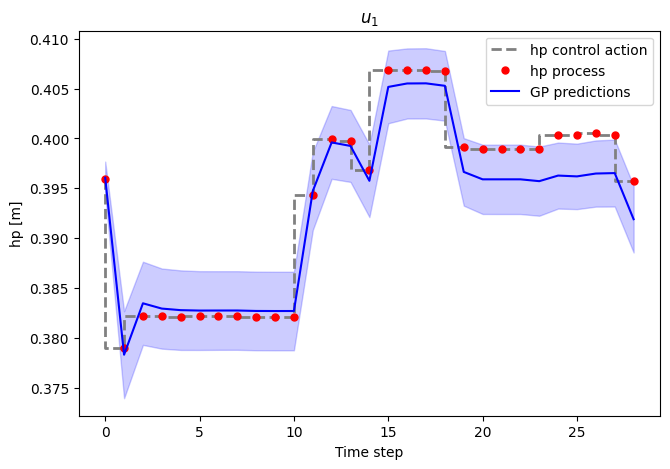

In [157]:
fig, ax = plt.subplots(figsize=(7.5, 5))  # Adjusted figure size for a single plot
ax.step(data_mpc['U_list'][0, :, 0],  '--', color='grey', label='hp control action', linewidth=2)
ax.plot(data_mpc['X_list'][7, 1:30, 0], '.', color='red', label='hp process', markersize=10)
ax.plot(hp_firststep_values, 'b-', label='GP predictions')
ax.fill_between(range(29), hp_firststep_values - 2*np.sqrt(YstdGP_hp_values), hp_firststep_values + 2*np.sqrt(YstdGP_hp_values), color='b', alpha=0.2)
ax.set_xlabel('Time step')
ax.set_ylabel('hp [m]')
ax.legend(loc='best')
ax.title.set_text('$u_1$')

plt.show()  # Display the first plot

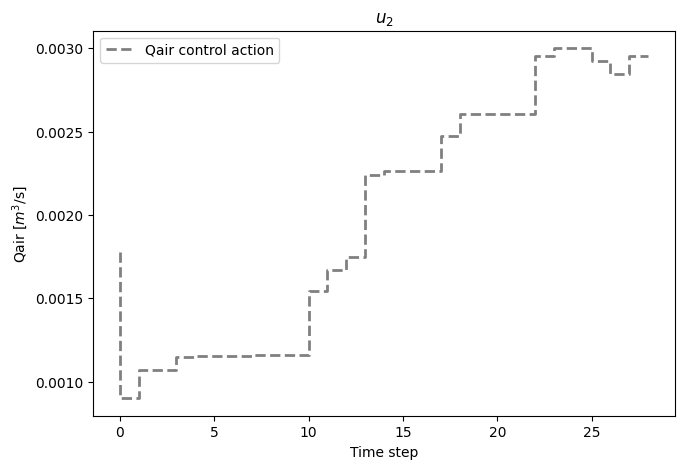

In [158]:
fig, ax = plt.subplots(figsize=(7.5, 5))  # Adjusted figure size for a single plot
ax.step(data_mpc['U_list'][1, :, 0],  '--', color='grey', label='Qair control action', linewidth=2)  # /0.181*100
ax.set_xlabel('Time step')
ax.set_ylabel('Qair [$m^3$/s]')
ax.legend(loc='best')
ax.title.set_text('$u_2$')

plt.show()  # Display the second plot